In [65]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [66]:
bag = rosbag.Bag('/home/uware/rosbags/static/rotation/36h11/s_yaw_36h11_5m_720_30.bag')

# create variables
target = 'yaw'
true_value = 'true_yaw'

# input values in degrees. the order matters, it will be used for binning 
input_vals = [0,15,30,45,60]

In [67]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t

    # conversion to euler
    rotation_quat = msg.transforms[0].transform.rotation
    pitch, yaw, roll = tf.transformations.euler_from_quaternion([rotation_quat.x,rotation_quat.y,rotation_quat.z,rotation_quat.w], axes='rxyz')

    # all rotations
    # rotation_euler = (np.degrees(pitch), np.degrees(yaw), np.degrees(roll))

    # create row
    row={'time': time.to_sec(), target: np.degrees(yaw)}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [68]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,yaw
0,0.000000,-12.746778
1,1.784066,-13.105525
2,2.198992,4.986373
3,2.634059,-12.174796
4,2.958256,-11.399898
...,...,...
515,67.393595,57.980902
516,67.505890,57.848906
517,67.607732,57.948023
518,67.706424,58.250438


<AxesSubplot:xlabel='relative_time'>

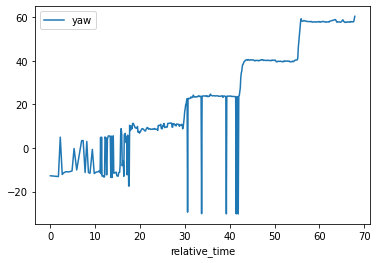

In [69]:
# initial graph
df.plot(x='relative_time', y=target)

In [70]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 20)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [71]:
# the amount of data points we are left with
len(x[peaks])

126

In [72]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='yaw'>

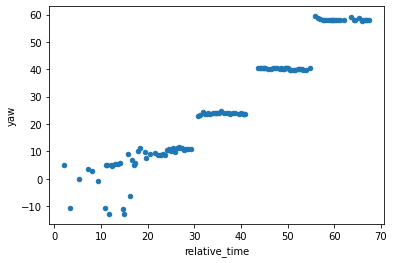

In [73]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [74]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets['relative_time'], bins=[0,17.5,30,43,55,70], labels=input_vals)
df_filtered_by_targets

,relative_time,yaw,true_yaw
2,2.198992,4.986373,0
5,3.478456,-10.840173,0
9,5.278469,-0.242172,0
12,7.302474,3.413976,0
14,8.115357,3.011608,0
...,...,...,...
504,66.186379,57.906126,60
507,66.515814,57.901692,60
510,66.833672,58.010012,60
512,67.051170,58.055087,60


In [75]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [76]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [77]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.tail(2)

,relative_time,yaw,true_yaw,error
78,17.013778,5.023751,0,-5.023751
80,17.233020,5.893520,0,-5.893520
184,28.664411,10.892730,15,4.107270
190,29.310756,10.862980,15,4.137020
294,40.661987,23.681538,30,6.318462
296,40.882658,23.689624,30,6.310376
414,54.007882,39.884223,45,5.115777
421,54.774594,40.430948,45,4.569052
512,67.051170,58.055087,60,1.944913
515,67.393595,57.980902,60,2.019098


In [78]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_yaw,,,,,,,,
0,22.0,-0.420700,7.351425,-8.911731,-5.404285,-4.848573,4.756134,12.864567
15,25.0,4.896664,1.104314,3.535386,3.996308,4.621423,6.028017,7.370091
30,24.0,6.163923,0.337374,5.266534,6.054710,6.104448,6.289016,7.219348
45,30.0,4.792201,0.268058,4.431278,4.569451,4.721084,5.070646,5.278360
60,25.0,1.858991,0.385790,0.666919,1.884892,1.989988,2.085046,2.226003


In [79]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

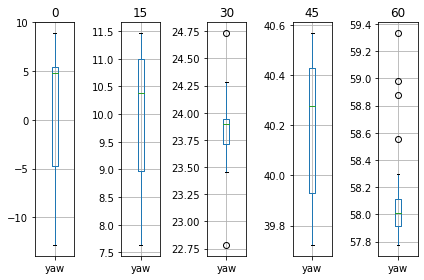

In [80]:
box_plotter(target)

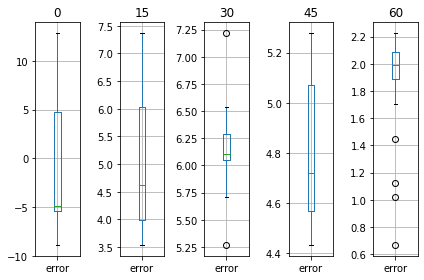

In [81]:
box_plotter('error')

In [82]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df_filtered_by_targets)

,relative_time,yaw,true_yaw,error
2,2.198992,4.986373,0,-4.986373
5,3.478456,-10.840173,0,10.840173
9,5.278469,-0.242172,0,0.242172
12,7.302474,3.413976,0,-3.413976
14,8.115357,3.011608,0,-3.011608
17,9.356602,-0.649240,0,0.649240
22,10.872612,-10.496842,0,10.496842
25,11.194517,4.895393,0,-4.895393
27,11.406546,4.970589,0,-4.970589
31,11.842602,-12.780872,0,12.780872
